In [1]:
import numpy as np
import math
import heapq
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
class AStart:
    def __init__(self, length:int, width:int, nets:list, macros:list, edge_capacity:np.ndarray, max_step:int) -> None:
        self.length = length
        self.width = width

        self.nets = nets
        self.macros = macros
        self.initial_capacity = edge_capacity.copy()
        self.initial_capacity.setflags(write=False)
        self.edge_capacity = edge_capacity.copy()
        self.max_capacity = np.max(self.edge_capacity) + 1 # plus one to account for the behavior of gym.MultiDiscrete
        self.max_step = max_step
        self.total_reward = 0

        self.pin_counter = 0 # counts the number of pins within a net that have been routed
        self.net_counter = 0 # counts the number of nets that have been routed
        self.step_counter = 0 # counts the number of steps elapsed for the current episode
        #self.change_net_flag = False # tells the step function to change to a new multi-pin net
        #self.change_pin_flag = False # tells the step function to change to a new 2-pin net
        self.done_flag = False 

        #self.path_x = self.generate_path_list(self.nets)
        #self.path_y = self.generate_path_list(self.nets)
        self.path = self.generate_path_list(self.nets)

        # decompose the multi-pin nets into 2-pin nets
        self.decomposed_nets = []
        for net in self.nets:
            self.decomposed_nets.append(self.prim_mst(net))

    def generate_path_list(self, nets:list):
        """
        Generate the list data structure to hold the path traveled by the agent
        """
        path = []
        for i in range (len(nets)):
            path.append([])
            for _ in range (len(nets[i])-1):
                path[i].append([])
        return path
    
    def astar(self, start, goal, blocked_nodes):
        def heuristic(a, b):
            # Manhattan distance heuristic
            return abs(a[0] - b[0]) + abs(a[1] - b[1])
        
        open_list = []
        heapq.heappush(open_list, (0, start))
        came_from = {}
        g_score = {start: 0}
        
        while open_list:
            _, current = heapq.heappop(open_list)
            
            if current == goal:
                path = []
                while current in came_from:
                    path.append(current)
                    current = came_from[current]
                path.append(start)
                path.reverse()
                return path
            
            for dx, dy in [(1, 0), (-1, 0), (0, 1), (0, -1)]:
                neighbor = current[0] + dx, current[1] + dy
                
                if neighbor in blocked_nodes:
                    continue
                
                tentative_g = g_score[current] + 1
                
                if neighbor not in g_score or tentative_g < g_score[neighbor]:
                    came_from[neighbor] = current
                    g_score[neighbor] = tentative_g
                    heapq.heappush(open_list, (tentative_g + heuristic(neighbor, goal), neighbor))
        
        return None  # No path found
    
    def compute_new_position(self, agent_position:tuple, action:int):
        """
        Compute new agent positions
        """
        if action == 0: # up
            new_position = (agent_position[0], agent_position[1]+1)
        elif action == 1: # right
            new_position = (agent_position[0]+1, agent_position[1])
        elif action == 2: # down
            new_position = (agent_position[0], agent_position[1]-1)
        elif action == 3: # left
            new_position = (agent_position[0]-1, agent_position[1])
        
        return new_position
    
    def update_capacity(self, agent_position:tuple, action:int):
        """
        Update the edge capacities after taking an action
        """

        # reduce the capacity of the current node
        self.edge_capacity[agent_position[0]][agent_position[1]][action] += -1

        # reduce the capacity of the next node's corresponding edge
        new_node = self.compute_new_position(agent_position, action)
        corresponding_edge = (action +2) % 4
        self.edge_capacity[new_node[0]][new_node[1]][corresponding_edge] += -1
    
    def determine_action(self, a:tuple, b:tuple) -> int:
        """Based on the start and end point of a transition, determine the action"""
        if a[0] == b[0]: # the action will either be up or down
            if b[1] > a[1]:
                action = 0
            else:
                action = 2
        else: # the action will be right or left
            if b[0] > a[0]:
                action = 1
            else:
                action = 3
        
        return action
    
    def route(self):
        while True:
            start_node = self.decomposed_nets[self.net_counter]['u'][self.pin_counter]
            goal_node = self.decomposed_nets[self.net_counter]['v'][self.pin_counter]
            path = self.astar(start_node, goal_node, self.macros)
            for i in range(len(path)-1):
                action = self.determine_action(path[i], path[i+1])
                self.update_capacity(path[i], action)
            # compute the reward
            reward = 10 - (len(path) -2)
            self.total_reward += reward
            self.path[self.net_counter][self.pin_counter] = path
            self.update_counters()

            if self.done_flag:
                break

    def update_counters(self):
        # one 2-pin net within one multi-pin net is done
        self.pin_counter += 1
        #self.change_pin_flag = True

        if self.pin_counter == len(self.nets[self.net_counter]) - 1:
            # this multi-pin net is done
            self.pin_counter = 0
            self.net_counter += 1
            #self.change_net_flag = True
            if self.net_counter == len(self.nets):
                # all nets are done, raise the done flag
                self.done_flag = True
    
    def prim_mst(self, pins):
        """
        Compute the Minimum Spanning Tree (MST) using Prim's algorithm.

        Args:
            pins (list): List of (x, y) coordinates representing the pin locations.

        Returns:
            dict: a dictionary containing the vertices of all the edges in the MST

        Note:
            - The pins list should contain at least two points.
        """

        def euclidean_distance(p1, p2):
            """
            Compute the Euclidean distance between two points.

            Args:
                p1 (tuple): First point (x, y) coordinates.
                p2 (tuple): Second point (x, y) coordinates.

            Returns:
                float: Euclidean distance between the two points.
            """
            x1, y1 = p1
            x2, y2 = p2
            return math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
        
        distances = {}
        for i in range(len(pins)):
            for j in range(i+1, len(pins)):
                p1 = pins[i]
                p2 = pins[j]
                distances[(i, j)] = euclidean_distance(p1, p2)
                distances[(j, i)] = distances[(i, j)]  # Add symmetric distance
        
        # Initialize
        num_pins = len(pins)
        visited = [False] * num_pins
        mst_u = []
        mst_v = []
        start_vertex = 0
        visited[start_vertex] = True
        
        # Create a priority queue
        pq = []
        
        # Mark the initial vertex as visited
        for i in range(num_pins):
            if i != start_vertex:
                heapq.heappush(pq, (distances[(start_vertex, i)], start_vertex, i))
        
        # Update the priority queue and perform Prim's algorithm
        while pq:
            if (len(mst_u) == len(pins) -1): # for n pins, the MST should at most have n-1 edges
                break

            weight, u, v = heapq.heappop(pq)
            
            if visited[v]:
                #print(f"Skipping edge: {weight} - {u} - {v}")
                continue
            
            # Prim's algorithm iteration
            visited[v] = True
            mst_u.append(pins[u])
            mst_v.append(pins[v])
            
            for i in range(num_pins):
                if not visited[i]:
                    heapq.heappush(pq, (distances[(v, i)], v, i))
        
        mst = {'u':mst_u,'v':mst_v}

        return mst
    
    def render(self):
        """
        Plot the agent's path
        """
        colors = cm.rainbow(np.linspace(0, 1, len(self.path)))

        for i in range(len(self.path)):
            color = colors[i]
            for j in range(len(self.path[i])):
                path_x, path_y = zip(*self.path[i][j])
                plt.plot(path_x, path_y, color = color)

        # plot the pins
        i = 0
        for net in self.nets:
            color = colors[i]
            x_coords, y_coords = zip(*net)
            plt.scatter(x_coords, y_coords, color = color)
            i += 1

        # plot the macro pins
        for point in self.macros:
            x, y = point
            plt.scatter(x,y, color='black')

        # Set the labels and title
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title('Nets')

        # Set the x and y axis ticks
        plt.xticks(range(0, self.length))
        plt.yticks(range(0, self.width))

        # Set the grid
        plt.grid(color='blue', linestyle='--', linewidth=0.5)

        fig = plt.gcf()
        fig.set_size_inches(self.length/4, self.width/4)

        # Show the plot
        plt.show()
    
    def heatmap(self):
        """Generate the horizontal and vertical edge usage heat maps."""
        horizontal_edge_index = 1 # indices for the up and right edge
        vertical_edge_index = 0
        shape = self.edge_capacity.shape
        horizontal_usage = self.edge_capacity[0:shape[0]-1, :, [horizontal_edge_index]].squeeze().transpose()
        vertical_usage = self.edge_capacity[:, 0:shape[1]-1, [vertical_edge_index]].squeeze().transpose()
        ticks = np.arange(0,self.max_capacity)
        
        plt.figure()
        sns.heatmap(horizontal_usage, annot=True, cmap="Reds", square=True, cbar_kws={"ticks":ticks})
        plt.gca().invert_yaxis()
        plt.title("Horizontal Heat Map")
        fig = plt.gcf()
        fig.set_size_inches(self.length/4, self.width/4)
        plt.show()

        plt.figure()
        sns.heatmap(vertical_usage, annot=True, cmap="Reds", square=True, cbar_kws={"ticks":ticks})
        plt.gca().invert_yaxis()
        plt.title("Vertical Heat Map")
        fig = plt.gcf()
        fig.set_size_inches(self.length/4, self.width/4)
        plt.show()

In [3]:
def parse(filepath):   
    with open(filepath) as file:
        lines = file.readlines()
        for i in range(len(lines)):
            lines[i] = lines[i].rstrip()
    length, width = lines[0].split()
    length, width = int(length), int(width)
    n_macros = int(lines[1])
    macros = []
    for i in range (2, 2+n_macros):
        macro_x, macro_y = lines[i].split()
        macros.append((int(macro_x), int(macro_y)))
    n_nets_index = i+1
    n_nets = int(lines[n_nets_index])
    first_net_index = n_nets_index+1
    nets = []
    for i in range(first_net_index, first_net_index+n_nets):
        net = []
        split_net_line = lines[i].split()
        n_pins = int(split_net_line[0])
        j = 1
        while (j < n_pins*2):
            pin_x, pin_y = int(split_net_line[j]), int(split_net_line[j+1])
            net.append((pin_x, pin_y))
            j+=2
        nets.append(net)

    return length, width, macros, nets
benchmark = "stdcell"
length, width, macros, nets = parse("/home/brucexi2/UBC-EECE-597_multi-agent-RL-IC-routing/benmarks/{}.infile".format(benchmark))

In [4]:
#nets = [[(2,1), (2,3), (3,3), (4,2)],[(1,4), (3,4), (4,4)]]
#macros = [(0,2), (1,2)]
#length = 6
#width = 6
n_nets = len(nets)
edge_capacity = np.full((length,width,4),n_nets)
max_step = 1000

In [5]:
env = AStart(length, width, nets, macros, edge_capacity, max_step)
env.route()

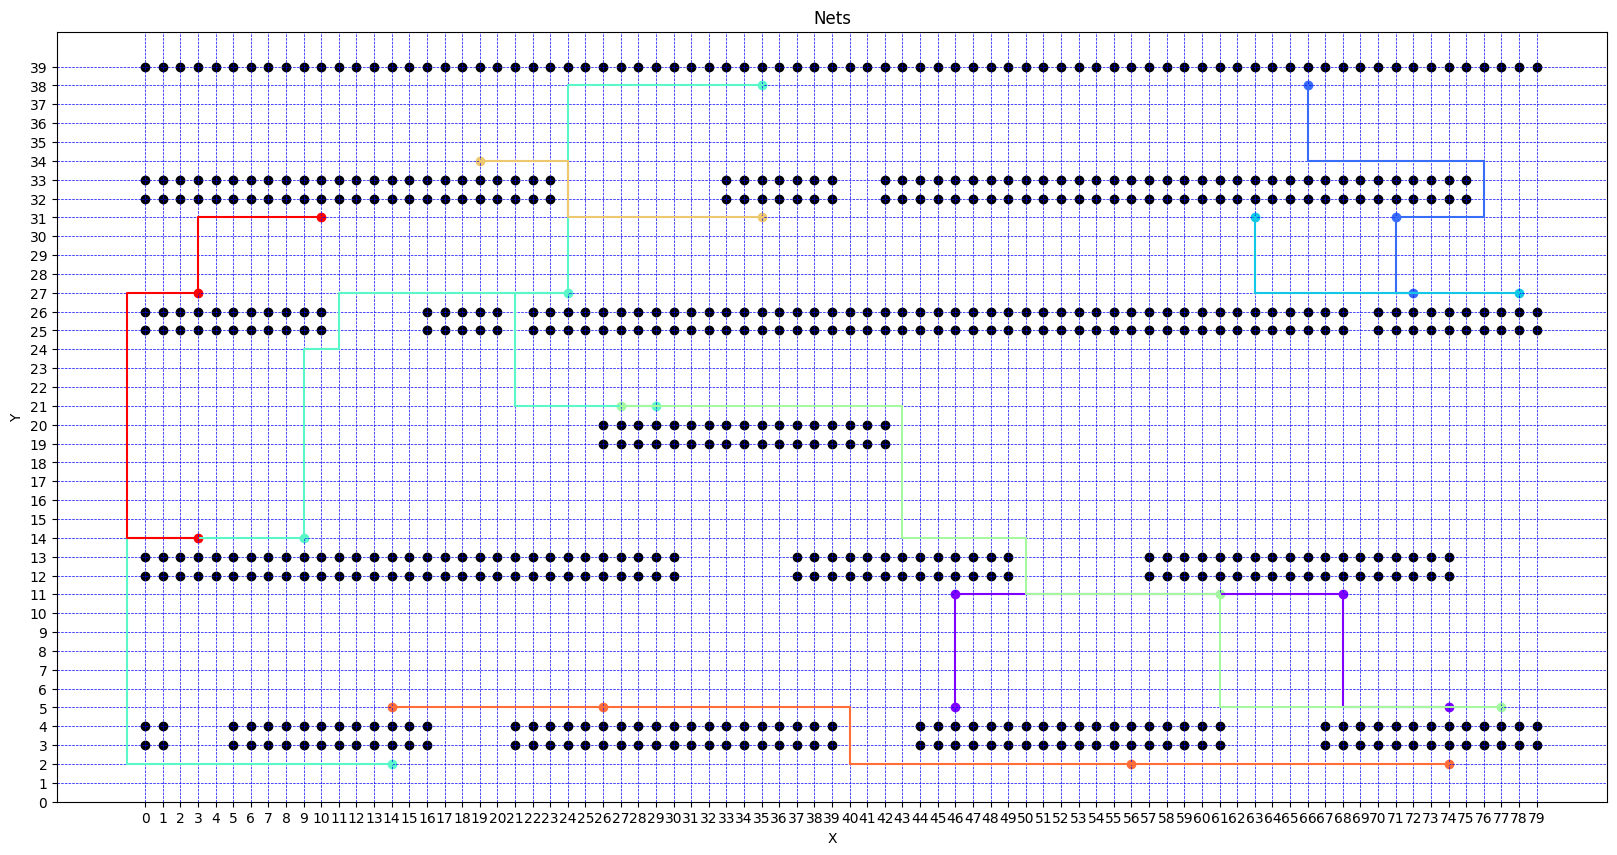

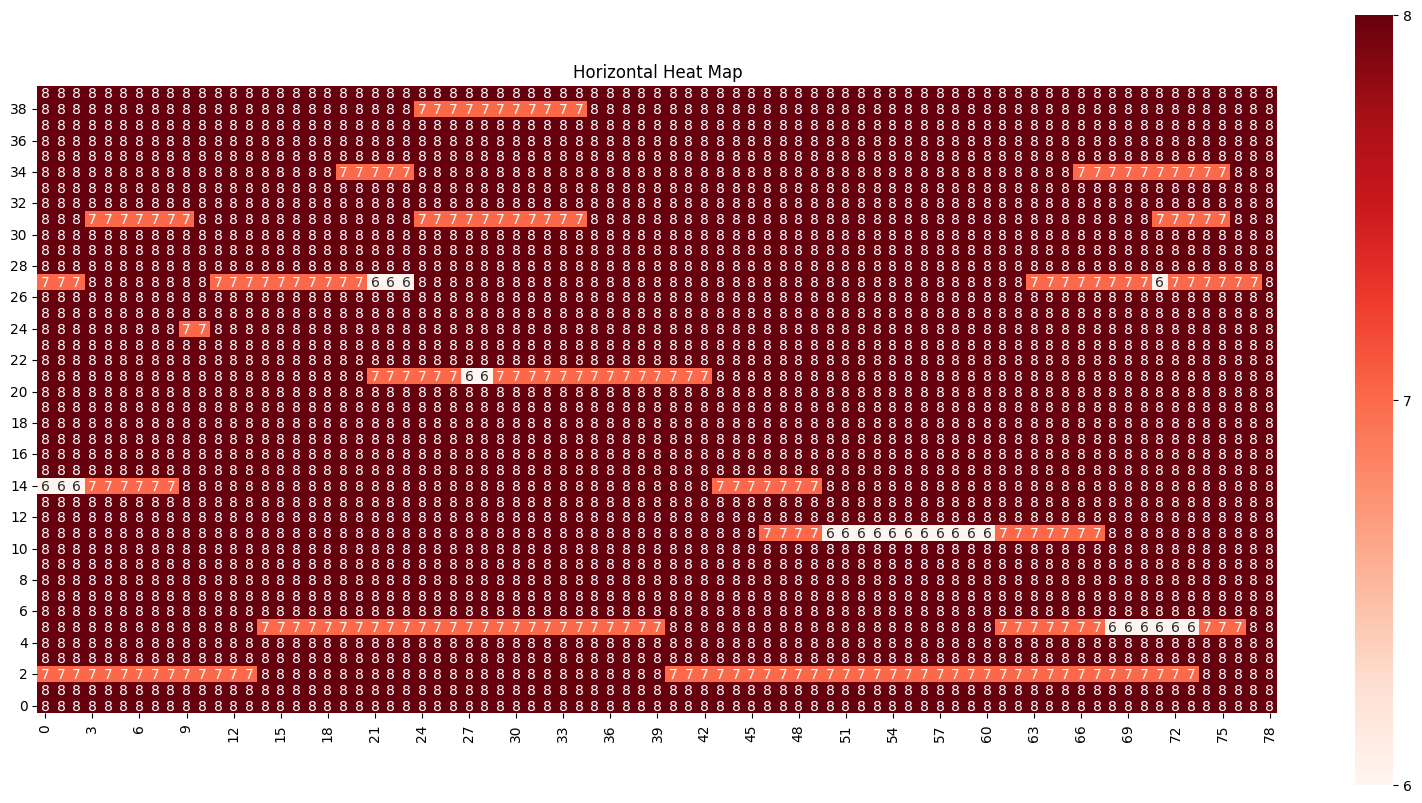

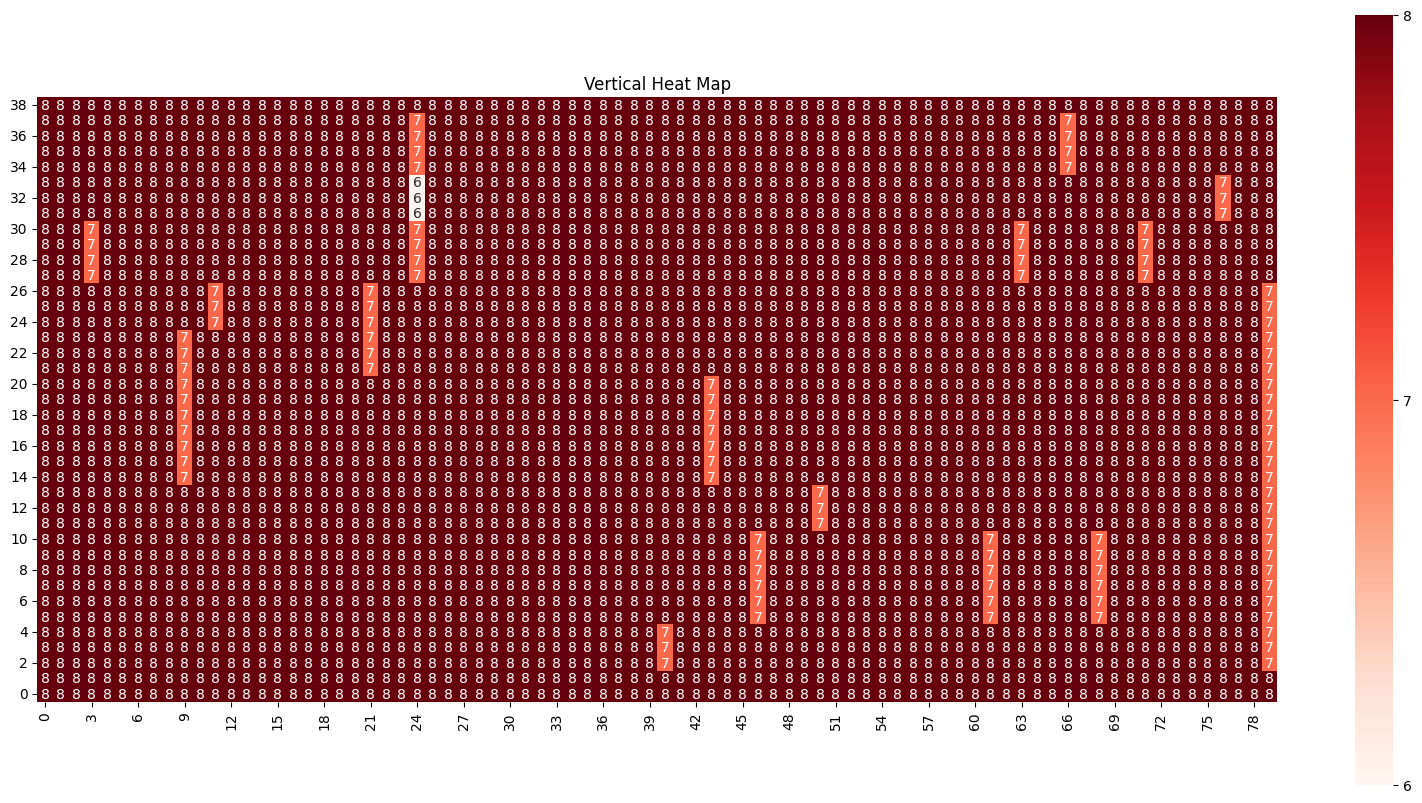

-172

In [6]:
env.render()
env.heatmap()
env.total_reward
